# RNN Sequence Prediction for Music Generation

Goal of this lecture is to train a network that is able to compose new music using a recurrent neural network (RNN) for sequence prediction.

---
### Course of Action

* Please write all executable python code in ```Code```-Cells (```Cell```->```Cell Type```->```Code```) and all Text as [Markdown](http://commonmark.org/help/) in ```Markdown```-Cells
* Describe your thinking and your decisions (where appropriate) in an extra Markdown Cell or via Python comments
* In general: discuss all your results and comment on them (are they good/bad/unexpected, could they be improved, how?, etc.). Furthermore, visualise your data (input and output).
* Write a short general conclusion at the end of the notebook
* Further experiments are encouraged. However, don't forget to comment on your reasoning.
* Use a scientific approach for all experiments (i.e. develop a hypothesis or concrete question, make observations, evaluate results)

### Submission

Upload the complete Notebook to [Ilias](https://learn.mi.hdm-stuttgart.de/) One Notebook per Group is enough. Edit the teammember table below. One Notebook per Group is enough. Edit the teammember table below.

**Important**: Also attach a HTML version of your notebook (```File```->```Download as```->```HTML```) in addition to the ```.ipynb```-File.

| Teammember |                    |
|------------|--------------------|
| 1.         | Geoffrey Hinton    |
| 2.         | Yoshua Bengio      |
| 3.         | Yann LeCun         |
| 4.         | Jürgen Schmidhuber |
---

## Prerequisities
1. Make sure you have a general understanding how RNNs are able to take time-series input and predict the future. A general overview of RNNs and different architectures can be found in the Machine Learning lecture [here](https://gitlab.mi.hdm-stuttgart.de/maucher/ML/blob/master/nb/RecurrentNeuralNetworks.ipynb). A practical example how future samples can be predicted can be found [here](https://gitlab.mi.hdm-stuttgart.de/maucher/ML/blob/master/nb/LSTMtemperature.ipynb). 

2. Make sure to have the following python libraries installed (e.g. via ```pip install```)
    * tensorflow
    * keras (or use the [```tensorflow.keras```](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/keras) module
    * [music21](http://web.mit.edu/music21/)
    * scipy

In [7]:
import os
import sys
import tensorflow as tf
import keras as k
from keras import layers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import RMSprop
from keras.utils import to_categorical
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split
import music21
from music21 import converter, instrument, note, chord, stream, midi, environment
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from collections import Counter
%matplotlib inline

env = environment.Environment()
env['musicxmlPath'] = '/Applications/MuseScore 4.app/Contents/MacOS/mscore'  # Replace with the path to your MusicXML viewer, e.g., MuseScore
env['midiPath'] = '/Applications/MidiPlayerPlus'  # Replace with the path to your MIDI player, e.g., VLC

%matplotlib inline


tensorflow-gpu = 2.4.1

In [82]:
tensorflow_version = tf.__version__

In [83]:
tensorflow_version

'2.11.0'

## Understanding the Input

To be able to compose new music (that ideally does not sound like random notes), the network needs to *listen* to music. Intuitivley the network will try to create music that sounds similar (tone color, rythm, etc.) to the music it listened to during the training.

We use midi-files due to their wide availability to generate the input to our network. A good ressource of free, classical midi-files can be found on the [Classical Piano Midi Page](http://www.piano-midi.de), however you can use any other ressource of midi-files (However, it works best with files with a single *track* (a single instrument).

A midi-file is a simple series of commands (e.g. ```note_on``` or ```note_off```) with a given time offset. To parse the midi-files we use the [music21](http://web.mit.edu/music21/) library. This library offers a wide range of musical analysis functions. We, for now, use it to parse midi files and to normalize the input.

#### Tasks:
* Download a set of midi-files for training (e.g. all compositions of a single artist).
* Load one of the files using music21
* Print the parsed file-structure
* Show an inline player for the file in your browser

#### Hints:
* Use a [```music21.converter```](http://web.mit.edu/music21/doc/moduleReference/moduleConverter.html#module-music21.converter) to read the file
* Use the [```Music21Object.show()```](http://web.mit.edu/music21/doc/moduleReference/moduleBase.html#music21.base.Music21Object.show) method to render the file in different formats.

In [2]:
music_midi = './midi_files/mozart/mz_311_1.mid'
music_data = converter.parse(music_midi)
print(music_data)

<music21.stream.Score 0x107c1aef0>


In [3]:
music_data.show('midi')


In [4]:
music_data.show('text')  # Show as text
music_data.show('musicxml')  # Show in MusicXML format (opens in the MusicXML viewer you've set earlier)

{0.0} <music21.metadata.Metadata object at 0x107c1b100>
{0.0} <music21.stream.Part 0x107c47340>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.instrument.Piano 'Piano right: Piano right'>
        {0.0} <music21.instrument.Piano 'Piano'>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.tempo.MetronomeMark allegrissimo Quarter=141.83>
        {0.0} <music21.key.Key of D major>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.chord.Chord A4 D5 F#4>
        {1.0} <music21.note.Rest quarter>
        {2.0} <music21.tempo.MetronomeMark Quarter=147.83>
        {2.0} <music21.note.Note G>
        {2.25} <music21.note.Note F#>
        {2.5} <music21.note.Note E>
        {2.75} <music21.note.Note F#>
        {3.0} <music21.note.Note A>
        {3.25} <music21.note.Note G>
        {3.5} <music21.tempo.MetronomeMark Quarter=135.83>
        {3.5} <music21.note.Note F#>
        {3.75} <music21.note.Note G>
    {4.0} <music21.stream.Measure 2

In [5]:
music_data.__class__

music21.stream.base.Score

As you can see, music21 automatically detects chords when multiple notes are played at the same time. This is helpful as this allows to represent multiple notes as a single symbol. Thus, the model can be trained on one-hot encoded data and still be able to generate polyphonic music.

The next step is to encode the songs into a list of tones. For simple music generation, we ignore the beat and tempo of the music and treat the songs as a series of equidistant notes or chords. 

#### Tasks:
* parse all midi files and put all notes and chords into a single list

#### Hints:
* Midi files may contain multiple *parts* (tracks, instruments, etc.) or are *flat* (notes and chords are not nested in parts). Use [```music21.stream.Stream.recurse()```](https://web.mit.edu/music21/doc/moduleReference/moduleStreamBase.html#music21.stream.base.Stream.recurse) to walk over all files and flatten the structure.
* For [```music21.note.Note```](http://web.mit.edu/music21/doc/moduleReference/moduleNote.html#note) objects, add the ```pitch``` to the tones list. For [```music21.chord.Chord```](http://web.mit.edu/music21/doc/moduleReference/moduleChord.html#chord) objects, join all notes in the chord using a seperator (e.g. ```.```). It is important to normalize the chord to its [```normalOrder```](http://web.mit.edu/music21/doc/moduleReference/moduleChord.html#music21.chord.Chord.normalOrder) to reduce the number of unique elements drastically without altering the training data too significantly. If the unnormalized chords are used, the training set is full of classes that only appear very rarely.

In [8]:
def extract_notes(midi_file, include_rests=False, only_first_part=False, normalize_chords=True):
    # Save note and durations separately
    notes = [] # Saves Notes as "C4", Chords as "D4_A2" and Pauses as "P"
    durations = [] # Saves one duration for every element in notes

    # Determine if all parts or only first part included
    iterator_obj = midi_file.getElementsByClass("Part")[0].flat.elements if only_first_part else midi_file.flat.elements

    # Filter elements for Notes, Chords and Rests
    for element in iterator_obj:
        # TYPE: Rest
        if type(element) == music21.note.Rest and include_rests:
            notes.append("P")
            durations.append(float(element.quarterLength))
        # TYPE: Note
        elif type(element) == music21.note.Note:
            notes.append(element.nameWithOctave)
            durations.append(float(element.quarterLength))
        # TYPE: Chord
        elif type(element) == music21.chord.Chord:
            chord_notes = [note.name if normalize_chords else note.nameWithOctave for note in element.notes]
            notes.append("_".join(chord_notes))
            durations.append(float(element.quarterLength))
    
    return notes, durations

In [9]:
def extract_notes_from_midi_files(folder_path, include_rests=False, only_first_part=False, normalize_chords=True, flatten_list=True, verbose=True, limit=100):
    # Save notes and durations separately
    files_notes = []
    files_durations = []

    #Parse all midi files
    for file in os.listdir(folder_path)[:limit if len(os.listdir(folder_path)) > limit else len(os.listdir(folder_path))]:
        if file.endswith(".mid"):
            try:
                midi_file = music21.converter.parse(folder_path + "/" + file)
                notes, durations = extract_notes(midi_file, include_rests=include_rests, only_first_part=only_first_part, normalize_chords=normalize_chords)

                files_notes.append(notes)
                files_durations.append(durations)
            except:
                print("Skipping corrupted midi file")
    
    # Flatten to one list, if flatten_list is True
    if flatten_list:
        files_notes = [item for sublist in files_notes for item in sublist]
        files_durations = [item for sublist in files_durations for item in sublist]
    
    # Print information
    if verbose:
        flatten_placeholder = [item for sublist in files_notes for item in sublist]
        print(f"Loaded notes from {len(os.listdir(folder_path))} midi files")
        print(f"Total number of notes: {len(files_notes) if flatten_list else len(flatten_placeholder)}")
        print(f"Number of unique notes: {len(set(files_notes)) if flatten_list else len(set(flatten_placeholder))}") 
              
    return files_notes, files_durations

In [10]:
def create_midi(notes, durations=None):
    if durations is None:
        durations = [.5]*len(notes)

    stream = music21.stream.Stream()

    for i, element in enumerate(notes):
        # TYPE: Rest
        if element == "P":
            stream.append(music21.note.Rest(quarterLength=durations[i]))
        # TYPE: Chord
        elif "_" in element:
            stream.append(music21.chord.Chord(element.split("_"), quarterLength=durations[i]))
        # TYPE: Note
        else:
            stream.append(music21.note.Note(element, quarterLength=durations[i]))

    return stream

In [11]:
import warnings
warnings.filterwarnings("ignore", message="Unable to determine instrument")

all_files_notes, all_files_durations = extract_notes_from_midi_files("./midi_files/mozart", flatten_list=True)
all_tracks = create_midi(all_files_notes[:10000], all_files_durations[:10000])  # Only first 10000 notes
all_tracks.show("midi")

Loaded notes from 21 midi files
Total number of notes: 55802
Number of unique notes: 638


In [85]:
"""
midi_dir = './midi_files/mozart/'  # Update this with the path to your MIDI files directory
all_files = os.listdir(midi_dir)
tones_list = []
unique_tones = []

for midi_file in all_files:
    if midi_file.endswith('.mid'):
        midi_path = os.path.join(midi_dir, midi_file)
        midi_data = converter.parse(midi_path)
        
        for element in midi_data.recurse():
            if isinstance(element, note.Note):
                tones_list.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                # Normalize the chord and join notes with a separator
                normalized_chord = '.'.join(str(n) for n in element.normalOrder)
                tones_list.append(normalized_chord)

"""

/Users/milosaleksic/miniconda3/envs/tensorflow/lib/python3.10/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/Users/milosaleksic/miniconda3/envs/tensorflow/lib/python3.10/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
/Users/milosaleksic/miniconda3/envs/tensorflow/lib/python3.10/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 1997 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
/Users/milosaleksic/miniconda3/envs/

This code will create a list called tones_list containing all the notes and chords from the parsed MIDI files. Notes will be represented as strings (e.g., 'C4', 'G#3'), and chords will be represented as strings of normalized note indices separated by dots (e.g., '0.3.7').

In [14]:
all_files_notes

['B-4',
 'B-3',
 'F4',
 'F3',
 'D4',
 'D3',
 'F4',
 'F3',
 'B-4',
 'B-3',
 'D5',
 'D4',
 'F5',
 'F4',
 'B-5',
 'D5',
 'F5',
 'E-_F_C',
 'E-5',
 'D5',
 'C5',
 'B-4',
 'A4',
 'G4',
 'F4',
 'E4',
 'F4',
 'G4',
 'A4',
 'B-4',
 'E-_F_C',
 'C_B-',
 'A4',
 'B-4',
 'C5',
 'D5',
 'E-5',
 'E5',
 'B-_D',
 'F5',
 'G5',
 'F5',
 'B-5',
 'D5',
 'F5',
 'E-5',
 'D5',
 'C5',
 'B-4',
 'A4',
 'G4',
 'F_C_E-',
 'F4',
 'E4',
 'F4',
 'G4',
 'A4',
 'B-4',
 'B-4',
 'D5',
 'B-4',
 'F_C_E-',
 'B-4',
 'C5',
 'B-4',
 'A4',
 'B-4',
 'G5',
 'B-_D',
 'D_B-',
 'B-4',
 'C5',
 'B-_F',
 'B-4',
 'A4',
 'B-4',
 'F5',
 'B-_D',
 'B-4',
 'C5',
 'B-4',
 'A4',
 'B-4',
 'C5',
 'F5',
 'B-_E-_G',
 'E-5',
 'C#5',
 'D5',
 'D_F_B-',
 'B-4',
 'C5',
 'B-4',
 'A4',
 'B-4',
 'G5',
 'A3',
 'F4',
 'B-4',
 'C5',
 'B-4',
 'A4',
 'B-4',
 'F5',
 'B-3',
 'F4',
 'B-4',
 'C5',
 'B-4',
 'A4',
 'B-4',
 'C5',
 'E-5',
 'E-_G_B-',
 'A4',
 'B-4',
 'D_F_B-',
 'D_B-_G',
 'F3',
 'A3',
 'G4',
 'C4',
 'E-4',
 'A_F#_D',
 'D_B-',
 'D4',
 'E-4',
 'G3',
 'G2',


In [15]:
all_files_durations

[2.0,
 2.0,
 1.0,
 1.0,
 2.0,
 2.0,
 1.0,
 1.0,
 2.0,
 2.0,
 1.0,
 1.0,
 2.0,
 2.0,
 0.5,
 0.5,
 0.5,
 3.0,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.25,
 3.0,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.5,
 1.0,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 3.0,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.25,
 0.25,
 0.25,
 1.0,
 3.0,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 1.0,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 1.0,
 1.0,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.5,
 1.0,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 1.0,
 3.0,
 3.0,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 1.0,
 1.0,
 1.0,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.25,
 3.0,
 1.0,
 0.25,
 1.0,
 1.0,
 0.25,
 1.0,
 0.25,
 2.0,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.5,
 0.25,
 0.5,
 1.0,
 0.25,
 1.0,
 0.5,
 3.0,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 1.0,
 3.0,
 0.5,
 0.5,
 0.5,
 0.

In [16]:
#tones_list[:100]

In [19]:
def plot_notes(notes_list, max_bars=40, chord_marker="_"):
    sorted_notes = Counter(notes_list).most_common()
    notes, counts = [val[0] for val in sorted_notes], [val[1] for val in sorted_notes]
    
    # General plot elements
    plt.figure(figsize=(12, 6))
    plt.bar(notes[:max_bars], counts[:max_bars], color=["orange" if chord_marker in val else "seagreen" for val in notes])
    plt.title("Notes & Chords Distribution", fontsize=14)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    
    # Print info that plot was cut
    if max_bars < len(notes):
        plt.text(40.2, 100, f"+ {len(notes) - max_bars} more", rotation=90)
    
    # Print percentage
    for x, y in zip(notes[:max_bars], counts[:max_bars]):
        plt.text(x, y + max(counts[:max_bars])/80, f"{(y / sum(counts) * 100):.1f}", ha="center", fontsize=8)
    
    # Legend
    legend_elements = [Patch(facecolor='seagreen', label='Notes'), Patch(facecolor='orange', label='Chords')]
    plt.legend(handles=legend_elements, bbox_to_anchor=(.995, .61))
    
    # Side plots 
    total_notes = [counts[i] for i in range(len(notes)) if chord_marker not in notes[i]]
    total_chords = [counts[i] for i in range(len(notes)) if chord_marker in notes[i]]
    
    num_plt = plt.axes([0.79, 0.63, 0.1, 0.2])
    num_plt.bar(["Notes", "Chords"], [sum(total_notes), sum(total_chords)], color=["seagreen", "orange"])
    num_plt.set_yticks([])
    num_plt.set_title("Total notes", fontsize=11)
    for x, y in zip(["Notes", "Chords"], [sum(total_notes), sum(total_chords)]):
        num_plt.text(x, y - max([sum(total_notes), sum(total_chords)])/8, str(y), ha="center", fontsize=8)
    
    per_plt = plt.axes([0.68, 0.63, 0.1, 0.2])
    per_plt.bar(["Notes", "Chords"], [len(total_notes), len(total_chords)], color=["seagreen", "orange"])
    per_plt.set_yticks([])
    per_plt.set_title("Different classes", fontsize=11)
    for x, y in zip(["Notes", "Chords"], [len(total_notes), len(total_chords)]):
        per_plt.text(x, y - max([len(total_notes), len(total_chords)])/8, str(y), ha="center", fontsize=8)
    
    plt.show()

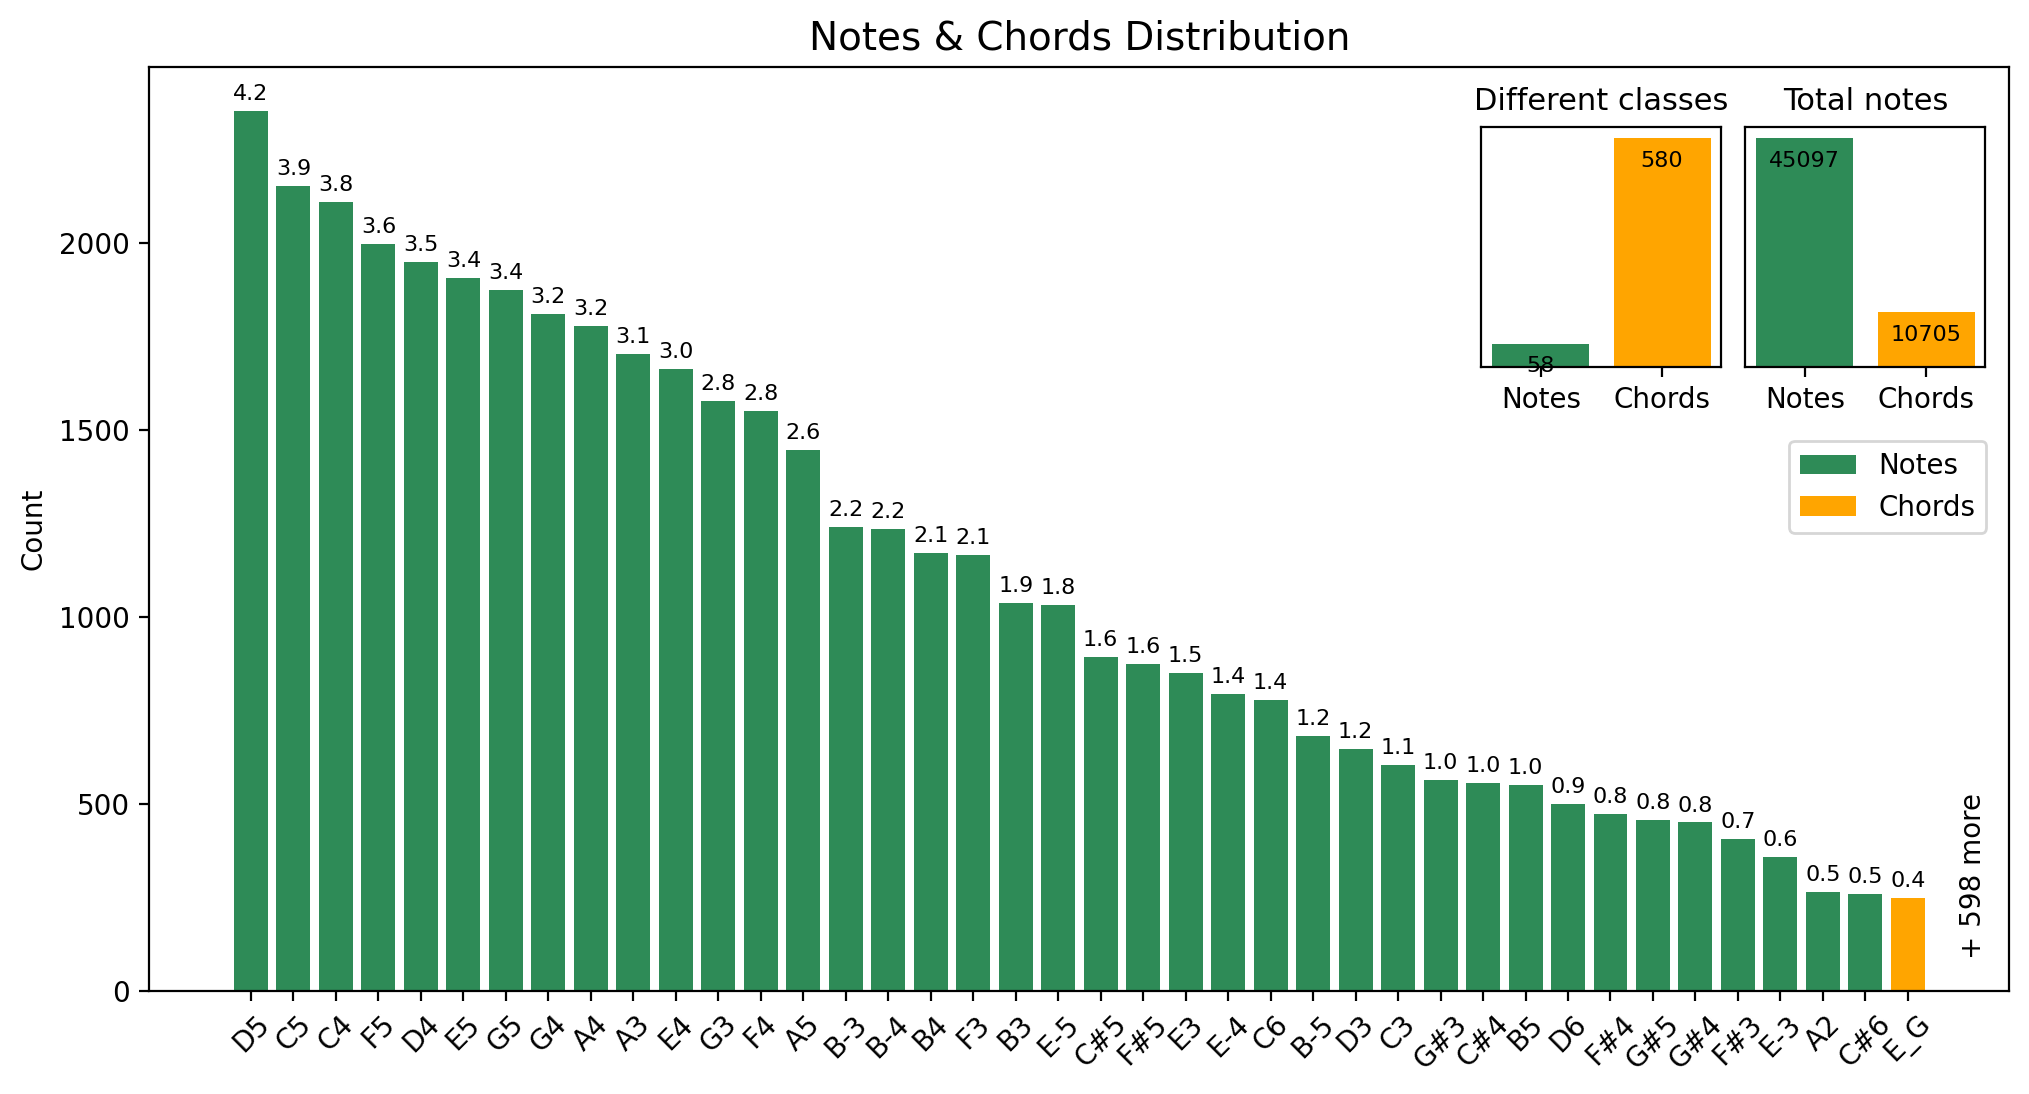

In [20]:
plot_notes(all_files_notes)

In [21]:
def limit_different_notes(notes, durations=None, limit=100):
    included_notes = [val[0] for val in Counter(notes).most_common()[:limit]]
    clipped_notes, clipped_durations = [], []

    for i in range(len(notes)):
        if notes[i] in included_notes:
            clipped_notes.append(notes[i])
            if durations is not None:
                clipped_durations.append(durations[i])

    print(f"Removed {len(notes) - len(clipped_notes)} notes to get to {len(set(clipped_notes))} classes ({len(clipped_notes)} total notes remaining)")
    return clipped_notes, clipped_durations

In [29]:
clipped_notes, clipped_durations = limit_different_notes(all_files_notes, all_files_durations)

Removed 4300 notes to get to 100 classes (51502 total notes remaining)


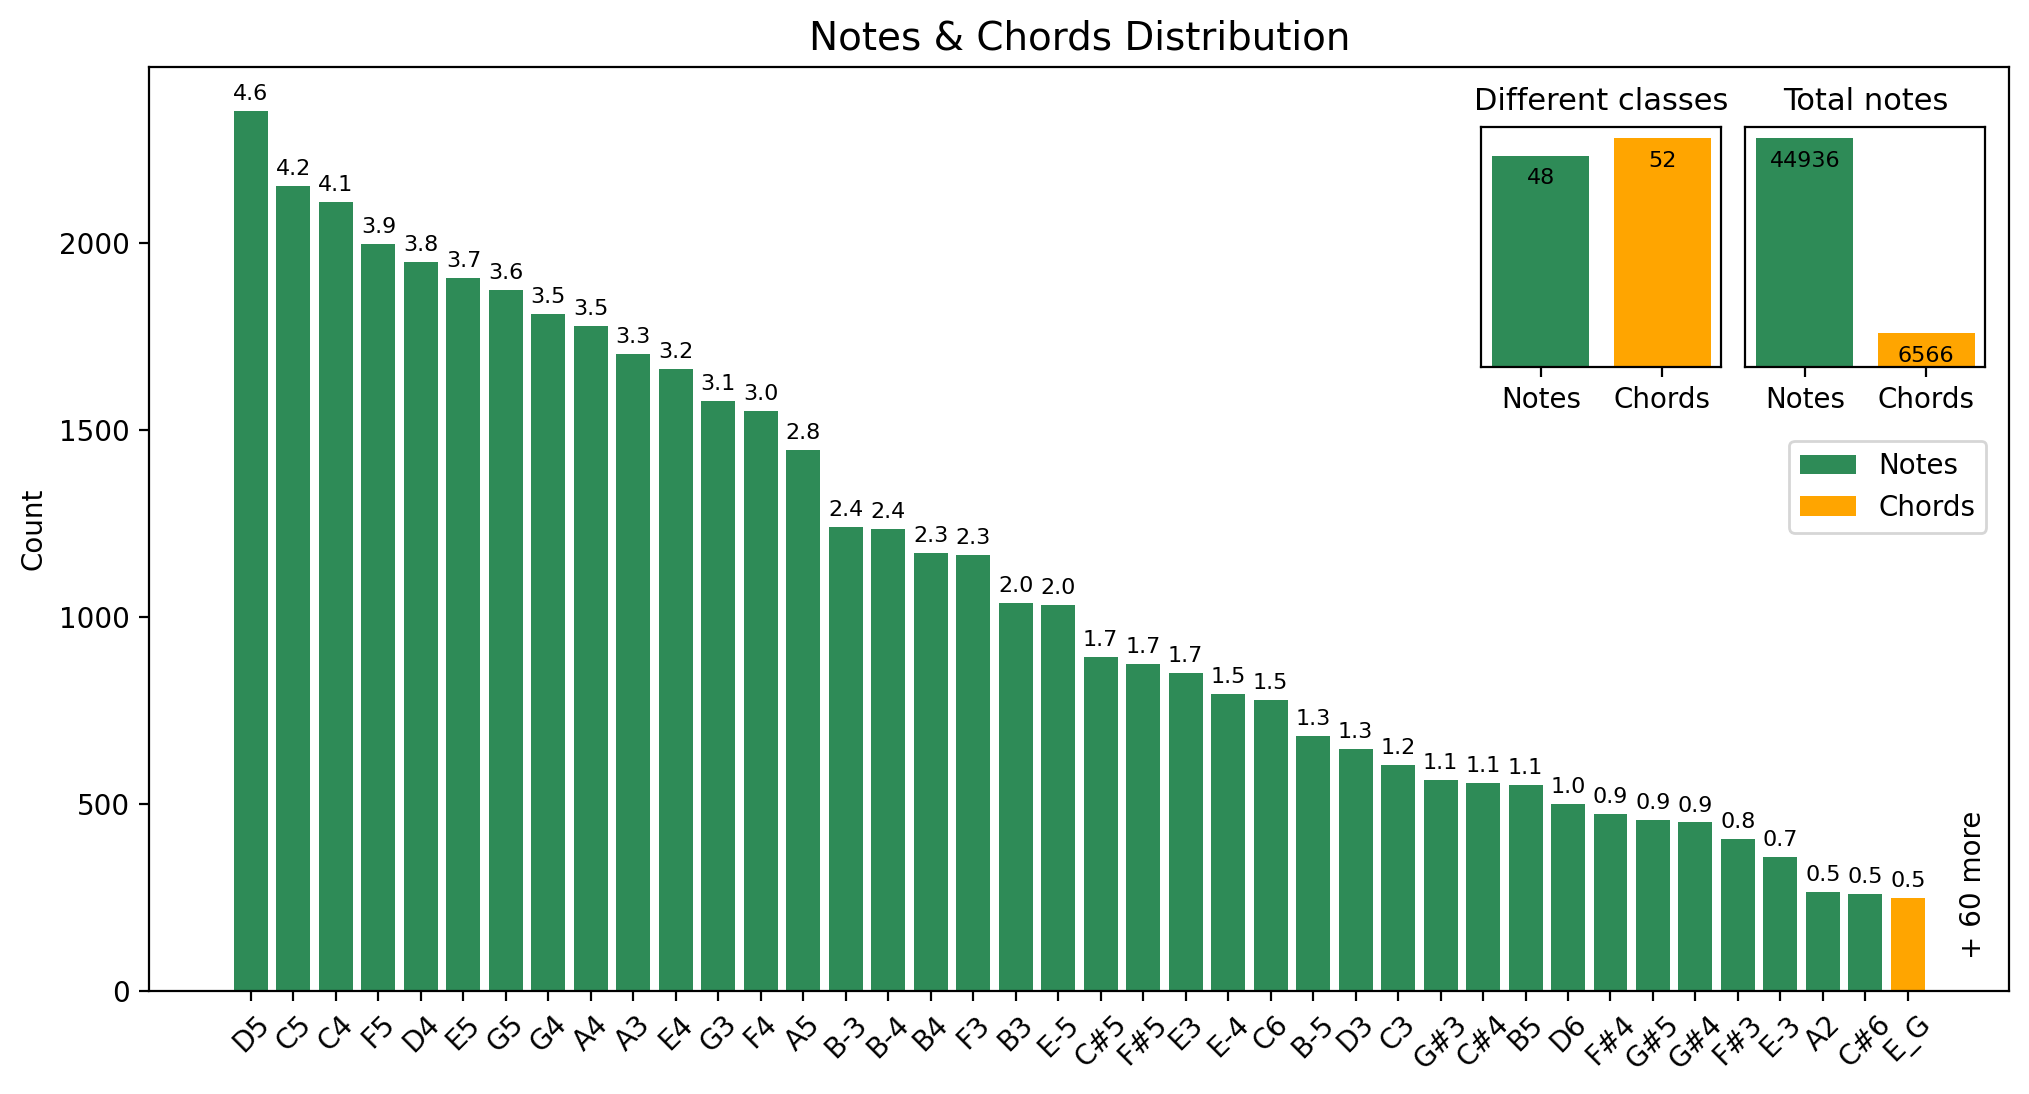

In [30]:
plot_notes(clipped_notes)

## Create training data

We train the network to predict the next note or chord after it has seen a sequence of previous tones. Therefore, each input element is a sequence of tones and the label is the next note or chord followed by this sequence.

Until now, each tone is represented by a string. For the output, this representation needs to be converted to one-hot encoded vectors to be able to train the model using categorical cross-entropy. The input needs to be mapped to floats in $[0,1|$ that are used as input to the network.

<img alt="preprocess" src="data:image/svg+xml,%3C%3Fxml%20version%3D%221.0%22%20encoding%3D%22UTF-8%22%20standalone%3D%22no%22%3F%3E%0D%0A%3C%21DOCTYPE%20svg%20PUBLIC%20%22-%2F%2FW3C%2F%2FDTD%20SVG%201.1%2F%2FEN%22%20%22http%3A%2F%2Fwww.w3.org%2FGraphics%2FSVG%2F1.1%2FDTD%2Fsvg11.dtd%22%3E%0D%0A%3Csvg%20width%3D%22100%25%22%20height%3D%22100%25%22%20viewBox%3D%220%200%202953%20591%22%20version%3D%221.1%22%20xmlns%3D%22http%3A%2F%2Fwww.w3.org%2F2000%2Fsvg%22%20xmlns%3Axlink%3D%22http%3A%2F%2Fwww.w3.org%2F1999%2Fxlink%22%20xml%3Aspace%3D%22preserve%22%20xmlns%3Aserif%3D%22http%3A%2F%2Fwww.serif.com%2F%22%20style%3D%22fill-rule%3Aevenodd%3Bclip-rule%3Aevenodd%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke-miterlimit%3A1.5%3B%22%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C985.827%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C965.827%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EF4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1068.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1045.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3ED4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1150.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1130.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EF4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1232.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1209.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1314.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1292.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EE4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1396.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1374.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC6%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1478.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1456.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1560.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1531.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1232.83%2C96%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1209.83%2C118%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1314.83%2C96%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1292.83%2C118%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EE4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1396.83%2C96%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1374.83%2C118%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC6%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1478.83%2C96%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1456.83%2C118%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1560.83%2C96%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28166%2C219%2C223%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1531.83%2C118%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1642.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1609.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EF%234%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1314.83%2C236%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1292.83%2C258%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EE4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1396.83%2C236%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1374.83%2C258%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC6%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1478.83%2C236%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1456.83%2C258%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1560.83%2C236%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1531.83%2C258%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1642.83%2C236%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28166%2C219%2C223%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1609.83%2C258%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EF%234%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1724.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1701.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC%23%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1396.83%2C376%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1374.83%2C398%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC6%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1478.83%2C376%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1456.83%2C398%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1560.83%2C376%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1531.83%2C398%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1642.83%2C376%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1609.83%2C398%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EF%234%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1724.83%2C376%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28166%2C219%2C223%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1701.83%2C398%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC%23%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1806.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1784.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1888.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1866.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB5%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C985.827%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M331.35%2C186.521L331.36%2C128.531%22%20style%3D%22fill%3Anone%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-dasharray%3A3%2C3%2C0%2C0%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C985.827%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M659.35%2C186.521L659.35%2C128.531%22%20style%3D%22fill%3Anone%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-dasharray%3A3%2C3%2C0%2C0%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C985.827%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M413.35%2C326.521L413.35%2C128.531%22%20style%3D%22fill%3Anone%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-dasharray%3A3%2C3%2C0%2C0%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C985.827%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M741.35%2C326.521L741.35%2C128.531%22%20style%3D%22fill%3Anone%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-dasharray%3A3%2C3%2C0%2C0%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C985.827%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M495.36%2C466.414L495.35%2C128.531%22%20style%3D%22fill%3Anone%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-dasharray%3A3%2C3%2C0%2C0%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C985.827%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M823.36%2C466.414L823.36%2C128.531%22%20style%3D%22fill%3Anone%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-dasharray%3A3%2C3%2C0%2C0%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C985.827%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M905.36%2C466.521L905.36%2C128.531%22%20style%3D%22fill%3Anone%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-dasharray%3A3%2C3%2C0%2C0%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.50007%2C0%2C0%2C1%2C1601.35%2C-303.498%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M275.736%2C494.2L275.736%2C479.848L374.611%2C479.848L374.611%2C466.521L415.61%2C487.024L374.611%2C507.526L374.611%2C494.2L275.736%2C494.2Z%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.50007%2C0%2C0%2C1%2C1683.35%2C-163.498%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M275.736%2C494.2L275.736%2C479.848L374.611%2C479.848L374.611%2C466.521L415.61%2C487.024L374.611%2C507.526L374.611%2C494.2L275.736%2C494.2Z%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.50007%2C0%2C0%2C1%2C1765.35%2C-23.4975%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M275.736%2C494.2L275.736%2C479.848L374.611%2C479.848L374.611%2C466.521L415.61%2C487.024L374.611%2C507.526L374.611%2C494.2L275.736%2C494.2Z%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1103.37%2C6.19147%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3EX%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C437.584%2C-364.362%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3Eseq%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22602.974px%22%20y%3D%22590.044px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A36.438px%3B%22%3E4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C383.584%2C-514.362%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3Enotes%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C437.584%2C-234.362%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3Eseq%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22602.974px%22%20y%3D%22590.044px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A36.438px%3B%22%3E5%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C437.584%2C-94.3615%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3Eseq%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22602.974px%22%20y%3D%22590.044px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A36.438px%3B%22%3E6%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%28-0.00034298%2C1%2C-1%2C-0.00034298%2C1573.35%2C-16.572%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3E...%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%28-0.00034298%2C1%2C-1%2C-0.00034298%2C1570.03%2C-421.634%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3E...%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1314.37%2C6.19147%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3Ey%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.00023754%2C0.71323%2C-4.12755%2C0.00137467%2C4031.46%2C247.776%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22353.101px%22%20y%3D%22598.079px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A79.542px%3B%22%3E%7D%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.00023754%2C0.71323%2C-1.03072%2C0.000343278%2C2446.05%2C248.332%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22353.101px%22%20y%3D%22598.079px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A79.542px%3B%22%3E%7D%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%3C%2Fsvg%3E%0D%0A" />

#### Tasks: 
* Create the training elements by following the *shifting* procedure depicted above
* normalize the input sequences to $[0,1|$ and one-hot encode the labels

#### Hints:
* Use a sequence length of ~50-100 notes
* create a mapping from the string-representation of a tone to an int and vice versa
* use [```keras.utils.to_categorical```](https://keras.io/api/utils/python_utils/#tocategorical-function) to convert an integer to a one-hot vector

In [23]:
def create_note_to_int_mapping(notes_list, int_to_note=False):
    notes_map = {}
    for i, note in enumerate(set(notes_list)):
        if int_to_note:
            notes_map[i] = note
        else:
            notes_map[note] = i
        
    return notes_map

In [26]:
note_mapping = create_note_to_int_mapping(clipped_notes)

In [28]:
print(note_mapping)

{'A4': 0, 'D_D': 1, 'D_E': 2, 'D_C': 3, 'C_B-': 4, 'E3': 5, 'C_A': 6, 'D4': 7, 'E-3': 8, 'C#3': 9, 'G#3': 10, 'E5': 11, 'G_D': 12, 'A_B': 13, 'B_B': 14, 'F6': 15, 'B-3': 16, 'C4': 17, 'D_F#': 18, 'A_A': 19, 'F_D': 20, 'F#5': 21, 'D6': 22, 'G_C': 23, 'C6': 24, 'C#5': 25, 'D_B-': 26, 'E_C': 27, 'G_A': 28, 'E_G': 29, 'D_F': 30, 'E_E': 31, 'B-_G': 32, 'F_G': 33, 'F4': 34, 'C#_A': 35, 'B_G': 36, 'G_G': 37, 'G_E-': 38, 'E-6': 39, 'A5': 40, 'G_B-': 41, 'D3': 42, 'G_B': 43, 'G_E': 44, 'E2': 45, 'E_C#': 46, 'G_F': 47, 'C5': 48, 'D5': 49, 'E_D': 50, 'C_C': 51, 'G4': 52, 'F#3': 53, 'G#4': 54, 'G2': 55, 'F5': 56, 'F_F': 57, 'G5': 58, 'C#6': 59, 'E-4': 60, 'B-2': 61, 'C#4': 62, 'B4': 63, 'F2': 64, 'F_G#': 65, 'A2': 66, 'B-_B-': 67, 'F#_A': 68, 'E-_C': 69, 'B2': 70, 'C#_E': 71, 'E_A': 72, 'E-5': 73, 'B-4': 74, 'B-_D': 75, 'B_D': 76, 'C3': 77, 'G3': 78, 'B5': 79, 'F3': 80, 'D_B': 81, 'C_E': 82, 'A_C#': 83, 'C_E-': 84, 'A_F#': 85, 'E4': 86, 'B-5': 87, 'E6': 88, 'B3': 89, 'A_G': 90, 'E-_G': 91, 'G#5': 

In [ ]:
def create_training_data(notes_list, seq_length=50):
    note_to_int_mapping = create_note_to_int_mapping(notes_list)
    train_data = {"input": [], "label": []}
    
    for i in range(len(notes_list))[:-(seq_length+1)]:
        seq = notes_list[i:i+seq_length]
        int_seq = [note_to_int_mapping[val] for val in seq]
        norm_seq = [val/len(note_to_int_mapping) for val in int_seq]
        train_data["input"].append(norm_seq)
        
        label_one_hot_enc = tf.keras.utils.to_categorical(note_to_int_mapping[notes_list[i+seq_length+1]], num_classes=len(note_to_int_mapping))
        train_data["label"].append(label_one_hot_enc)
        
    return train_data, note_to_int_mapping

In [40]:
""""
def create_training_data(tones_list, sequence_length=100):

    unique_tones = sorted(set(tones_list))
    tones_to_int = dict((tone, num) for num, tone in enumerate(unique_tones))
    int_to_tones = dict((num, tone) for num, tone in enumerate(unique_tones))

    input_sequences = []
    output_labels = []

    for i in range(len(tones_list) - sequence_length):
        input_sequence = tones_list[i: i + sequence_length]
        output_label = tones_list[i + sequence_length]

        input_sequences.append([tones_to_int[tone] for tone in input_sequence])
        output_labels.append(tones_to_int[output_label])

    n_unique_tones = len(unique_tones)

    # Normalize input sequences
    input_sequences_normalized = np.asarray(input_sequences) / float(n_unique_tones)

    # Reshape input sequences to the required format for RNN input (samples, time steps, features)
    input_sequences_reshaped = np.reshape(input_sequences_normalized, (len(input_sequences), sequence_length, 1))

    # One-hot encode labels
    output_labels_one_hot = to_categorical(output_labels)

    return input_sequences_reshaped, output_labels_one_hot, tones_to_int, int_to_tones, n_unique_tones
""""

In [41]:
#input_sequences_reshaped, output_labels_one_hot, tones_to_int, int_to_tones, n_unique_tones = create_training_data(tones_list, sequence_length=100)

In [42]:
#tones_to_int

{'0': 0,
 '0.1': 1,
 '0.1.3': 2,
 '0.2': 3,
 '0.2.6': 4,
 '0.2.7': 5,
 '0.3': 6,
 '0.3.5': 7,
 '0.3.6': 8,
 '0.3.6.9': 9,
 '0.3.7': 10,
 '0.4': 11,
 '0.4.6': 12,
 '0.4.7': 13,
 '0.5': 14,
 '0.6': 15,
 '1': 16,
 '1.2': 17,
 '1.2.4': 18,
 '1.3': 19,
 '1.3.7': 20,
 '1.4': 21,
 '1.4.7': 22,
 '1.4.7.10': 23,
 '1.4.7.9': 24,
 '1.5': 25,
 '1.5.8': 26,
 '1.6': 27,
 '1.7': 28,
 '10': 29,
 '10.0': 30,
 '10.0.2': 31,
 '10.0.3': 32,
 '10.0.4': 33,
 '10.1': 34,
 '10.1.4': 35,
 '10.11': 36,
 '10.11.1': 37,
 '10.2': 38,
 '10.2.3': 39,
 '10.2.5': 40,
 '10.3': 41,
 '11': 42,
 '11.0': 43,
 '11.0.2': 44,
 '11.1': 45,
 '11.1.2': 46,
 '11.2': 47,
 '11.2.4': 48,
 '11.2.5': 49,
 '11.2.5.7': 50,
 '11.2.6': 51,
 '11.3': 52,
 '11.3.6': 53,
 '11.4': 54,
 '2': 55,
 '2.3': 56,
 '2.3.5': 57,
 '2.4': 58,
 '2.4.5': 59,
 '2.4.6': 60,
 '2.4.8': 61,
 '2.4.9': 62,
 '2.5': 63,
 '2.5.7': 64,
 '2.5.8': 65,
 '2.5.8.11': 66,
 '2.5.9': 67,
 '2.6': 68,
 '2.6.9': 69,
 '2.7': 70,
 '2.8': 71,
 '3': 72,
 '3.4': 73,
 '3.4.5': 74,
 '

In [43]:
#int_to_tones

{0: '0',
 1: '0.1',
 2: '0.1.3',
 3: '0.2',
 4: '0.2.6',
 5: '0.2.7',
 6: '0.3',
 7: '0.3.5',
 8: '0.3.6',
 9: '0.3.6.9',
 10: '0.3.7',
 11: '0.4',
 12: '0.4.6',
 13: '0.4.7',
 14: '0.5',
 15: '0.6',
 16: '1',
 17: '1.2',
 18: '1.2.4',
 19: '1.3',
 20: '1.3.7',
 21: '1.4',
 22: '1.4.7',
 23: '1.4.7.10',
 24: '1.4.7.9',
 25: '1.5',
 26: '1.5.8',
 27: '1.6',
 28: '1.7',
 29: '10',
 30: '10.0',
 31: '10.0.2',
 32: '10.0.3',
 33: '10.0.4',
 34: '10.1',
 35: '10.1.4',
 36: '10.11',
 37: '10.11.1',
 38: '10.2',
 39: '10.2.3',
 40: '10.2.5',
 41: '10.3',
 42: '11',
 43: '11.0',
 44: '11.0.2',
 45: '11.1',
 46: '11.1.2',
 47: '11.2',
 48: '11.2.4',
 49: '11.2.5',
 50: '11.2.5.7',
 51: '11.2.6',
 52: '11.3',
 53: '11.3.6',
 54: '11.4',
 55: '2',
 56: '2.3',
 57: '2.3.5',
 58: '2.4',
 59: '2.4.5',
 60: '2.4.6',
 61: '2.4.8',
 62: '2.4.9',
 63: '2.5',
 64: '2.5.7',
 65: '2.5.8',
 66: '2.5.8.11',
 67: '2.5.9',
 68: '2.6',
 69: '2.6.9',
 70: '2.7',
 71: '2.8',
 72: '3',
 73: '3.4',
 74: '3.4.5',
 7

In [44]:
#n_unique_tones

229

In [45]:
#input_sequences_reshaped

array([[[0.78165939],
        [0.94759825],
        [0.86462882],
        ...,
        [0.88646288],
        [0.94759825],
        [0.88646288]],

       [[0.94759825],
        [0.86462882],
        [0.94759825],
        ...,
        [0.94759825],
        [0.88646288],
        [0.86462882]],

       [[0.86462882],
        [0.94759825],
        [0.78165939],
        ...,
        [0.88646288],
        [0.86462882],
        [0.88646288]],

       ...,

       [[0.79912664],
        [0.77729258],
        [0.79912664],
        ...,
        [0.66812227],
        [0.66812227],
        [0.66812227]],

       [[0.77729258],
        [0.79912664],
        [0.97816594],
        ...,
        [0.66812227],
        [0.66812227],
        [0.24017467]],

       [[0.79912664],
        [0.97816594],
        [0.98253275],
        ...,
        [0.66812227],
        [0.24017467],
        [0.30131004]]])

In [46]:
#input_sequences_reshaped.shape

(55702, 100, 1)

In [48]:
#output_labels_one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [49]:
#output_labels_one_hot.shape

(55702, 229)

## Create and train the Network

With the prepared training data, it is now possible to train the network. There are many variants of RNNs (e.g. unidirectional vs. bidirectional and LSTM vs. GRU). You can encouraged to try your own network architecture, however here is an example architecture as a starting point:

* 3 consecutive unidirectional recurrent layer with ```512``` [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/) unit, returning all sequence states (not only the last state) to feed into the next recurrent layer (except for the last layer) and [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) with a rate of ```0.3``` between each layer
* a [Dense](https://keras.io/api/layers/core_layers/dense/) layer with ```256``` neurons, ReLU activation and a dropout rate of ```0.3```
* another Dense layer for the output with softmax activation
* RMSProp optimizer using categorical-crossentropy as lossfunction

In [77]:
def build_model(input_shape, num_classes):
    model = tf.keras.Sequential()
    
    # Add the first LSTM layer with 512 units and return_sequences=True
    model.add(tf.keras.layers.LSTM(512, input_shape=input_shape, return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.3))

    # Add the second LSTM layer with 512 units and return_sequences=True
    model.add(tf.keras.layers.LSTM(512, return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.3))

    # Add the third LSTM layer with 512 units
    model.add(tf.keras.layers.LSTM(512))
    model.add(tf.keras.layers.Dropout(0.3))

    # Add a Dense layer with 256 neurons and ReLU activation
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))

    # Add the final Dense output layer with softmax activation
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    # Compile the model with RMSProp optimizer and categorical_crossentropy loss function
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

    return model

In [78]:
lstm_model = build_model((input_sequences_reshaped.shape[1], input_sequences_reshaped.shape[2]), output_labels_one_hot.shape[1])

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x29668b460>>

In [80]:
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 100, 512)          1052672   
                                                                 
 dropout_15 (Dropout)        (None, 100, 512)          0         
                                                                 
 lstm_13 (LSTM)              (None, 100, 512)          2099200   
                                                                 
 dropout_16 (Dropout)        (None, 100, 512)          0         
                                                                 
 lstm_14 (LSTM)              (None, 512)               2099200   
                                                                 
 dropout_17 (Dropout)        (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)              

In [57]:
input_shape = (input_sequences_reshaped.shape[1], input_sequences_reshaped.shape[2])

In [58]:
input_shape

(100, 1)

In [60]:
num_classes = output_labels_one_hot.shape[1]

In [61]:
num_classes

229

In [62]:
model = build_model(input_shape, num_classes)

As the training of a complex RNN can take a very long time, you should make sure to add a [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/) callback to your model to regularly save the parameters during training.

#### Tasks:
* train your model for 50-100 epochs

#### Hints:
* train your model on a reduced training set and for a single epoch first to make sure you have no programming errors
* the training can take a very long time, use the [Deeplearn Machines @ HDM](https://deeplearn.pages.mi.hdm-stuttgart.de/docs/) to speed up training (significantly!)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(input_sequences_reshaped, output_labels_one_hot, test_size=0.2, random_state=42)

In [65]:
X_train.shape

(44561, 100, 1)

In [66]:
X_train

array([[[0.79912664],
        [0.84279476],
        [0.86462882],
        ...,
        [0.55895197],
        [0.58515284],
        [0.84279476]],

       [[0.86026201],
        [0.86462882],
        [0.90829694],
        ...,
        [0.79912664],
        [0.90829694],
        [0.79912664]],

       [[0.99126638],
        [0.91266376],
        [0.82532751],
        ...,
        [0.91266376],
        [0.89082969],
        [0.93449782]],

       ...,

       [[0.76419214],
        [0.80786026],
        [0.76419214],
        ...,
        [0.76419214],
        [0.76419214],
        [0.97379913]],

       [[0.7860262 ],
        [0.99126638],
        [0.95196507],
        ...,
        [0.86899563],
        [0.82532751],
        [0.86899563]],

       [[0.85152838],
        [0.91266376],
        [0.45414847],
        ...,
        [0.85152838],
        [0.58515284],
        [0.85152838]]])

In [67]:
y_train.shape

(44561, 229)

In [68]:
X_test.shape

(11141, 100, 1)

In [69]:
X_test

array([[[0.18777293],
        [0.18777293],
        [0.18777293],
        ...,
        [0.6768559 ],
        [0.6768559 ],
        [0.58078603]],

       [[0.20524017],
        [0.83842795],
        [0.98253275],
        ...,
        [0.79912664],
        [0.94323144],
        [0.04803493]],

       [[0.94759825],
        [0.90829694],
        [0.91703057],
        ...,
        [0.95196507],
        [0.86899563],
        [0.80349345]],

       ...,

       [[0.98253275],
        [0.86462882],
        [0.75545852],
        ...,
        [0.83842795],
        [0.98253275],
        [0.14847162]],

       [[0.91266376],
        [0.86899563],
        [0.82532751],
        ...,
        [0.91266376],
        [0.75982533],
        [0.75982533]],

       [[0.84716157],
        [0.80349345],
        [0.84716157],
        ...,
        [0.75982533],
        [0.98689956],
        [0.89082969]]])

In [70]:
y_test.shape

(11141, 229)

In [71]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=64)

# Generating new Music

After training, the model should have learned to predict the note or chord after *listening* to a sequence of tones. If the model is good at this task, it means that it does know what sequence of tones *sounds right™* (given the training data has the same property).

To generate new music, you just need to let the network *listen* to a sequence of tones (the seed) and ask for the next note or chord. Then, append this predicted tone to the end of the seed (and remove the first entry), feed the new seed into the network and get for the next tone.

<img alt="rnn generation" src="data:image/svg+xml,%3C%3Fxml%20version%3D%221.0%22%20encoding%3D%22UTF-8%22%20standalone%3D%22no%22%3F%3E%0D%0A%3C%21DOCTYPE%20svg%20PUBLIC%20%22-%2F%2FW3C%2F%2FDTD%20SVG%201.1%2F%2FEN%22%20%22http%3A%2F%2Fwww.w3.org%2FGraphics%2FSVG%2F1.1%2FDTD%2Fsvg11.dtd%22%3E%0D%0A%3Csvg%20width%3D%22100%25%22%20height%3D%22100%25%22%20viewBox%3D%220%200%202953%20591%22%20version%3D%221.1%22%20xmlns%3D%22http%3A%2F%2Fwww.w3.org%2F2000%2Fsvg%22%20xmlns%3Axlink%3D%22http%3A%2F%2Fwww.w3.org%2F1999%2Fxlink%22%20xml%3Aspace%3D%22preserve%22%20xmlns%3Aserif%3D%22http%3A%2F%2Fwww.serif.com%2F%22%20style%3D%22fill-rule%3Aevenodd%3Bclip-rule%3Aevenodd%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke-miterlimit%3A1.5%3B%22%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C506.827%2C26%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28208%2C124%2C127%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C483.827%2C48%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C588.827%2C26%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28208%2C124%2C127%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C566.827%2C48%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EE4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C670.827%2C26%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28208%2C124%2C127%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C648.827%2C48%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC6%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C752.827%2C26%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28208%2C124%2C127%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C730.827%2C48%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C588.827%2C166%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28208%2C124%2C127%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C566.827%2C188%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EE4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C670.827%2C166%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28208%2C124%2C127%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C648.827%2C188%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC6%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C752.827%2C166%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28208%2C124%2C127%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C730.827%2C188%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C834.827%2C166%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C805.827%2C188%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C934.827%2C26%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C905.827%2C48%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1576.83%2C26%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1547.83%2C48%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1576.83%2C166%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1547.83%2C188%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C670.827%2C306%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28208%2C124%2C127%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C648.827%2C328%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC6%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C752.827%2C306%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28208%2C124%2C127%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C730.827%2C328%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C834.827%2C306%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C805.827%2C328%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C916.827%2C306%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C893.827%2C328%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EG4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1017.83%2C166%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C994.827%2C188%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EG4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1659.83%2C166%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1636.83%2C188%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EG4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1576.83%2C306%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1547.83%2C328%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1659.83%2C306%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1636.83%2C328%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EG4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C752.827%2C446%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28208%2C124%2C127%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C730.827%2C468%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C834.827%2C446%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C805.827%2C468%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C916.827%2C446%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C893.827%2C468%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EG4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C998.827%2C446%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C978.827%2C468%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EA4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1095.83%2C306%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1076.83%2C328%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EA4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1742.83%2C306%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1723.83%2C328%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EA4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1576.83%2C436%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1547.83%2C458%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1659.83%2C436%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1636.83%2C458%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EG4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1742.83%2C436%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1824.83%2C436%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1723.83%2C458%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EA4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.50007%2C0%2C0%2C1%2C796.352%2C-373.498%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M275.736%2C494.2L275.736%2C479.848L374.611%2C479.848L374.611%2C466.521L415.61%2C487.024L374.611%2C507.526L374.611%2C494.2L275.736%2C494.2Z%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.50007%2C0%2C0%2C1%2C878.844%2C-233.498%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M275.736%2C494.2L275.736%2C479.848L374.611%2C479.848L374.611%2C466.521L415.61%2C487.024L374.611%2C507.526L374.611%2C494.2L275.736%2C494.2Z%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.50007%2C0%2C0%2C1%2C957.352%2C-93.4975%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M275.736%2C494.2L275.736%2C479.848L374.611%2C479.848L374.611%2C466.521L415.61%2C487.024L374.611%2C507.526L374.611%2C494.2L275.736%2C494.2Z%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.50007%2C0%2C0%2C1%2C1039.35%2C46.5025%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M275.736%2C494.2L275.736%2C479.848L374.611%2C479.848L374.611%2C466.521L415.61%2C487.024L374.611%2C507.526L374.611%2C494.2L275.736%2C494.2Z%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C205.216%2C-531.178%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A37.5px%3B%22%3Eseed%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C460.216%2C-531.178%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A37.5px%3B%22%3Eprediction%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C745.116%2C-32.5778%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3E...%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1406.52%2C-42.2273%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3E...%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%282.01933e-16%2C-0.71323%2C4.12755%2C1.16899e-15%2C-1631.49%2C328.808%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22353.101px%22%20y%3D%22598.079px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A79.542px%3B%22%3E%7D%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%282.01933e-16%2C-0.71323%2C4.12755%2C1.16899e-15%2C-561.494%2C328.808%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22353.101px%22%20y%3D%22598.079px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A79.542px%3B%22%3E%7D%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%282.01933e-16%2C-0.71323%2C1.04117%2C2.94875e-16%2C458.116%2C328.808%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22353.101px%22%20y%3D%22598.079px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A79.542px%3B%22%3E%7D%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1123.22%2C-531.178%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A37.5px%3B%22%3Egenerated%20comp%3Ctspan%20x%3D%22777.062px%20%22%20y%3D%22569.231px%20%22%3Eo%3C%2Ftspan%3Esition%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%284.14714e-16%2C-6.7728%2C6.7728%2C4.14714e-16%2C1280.62%2C11356.2%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M1672.64%2C28.679L1593.64%2C28.904%22%20style%3D%22fill%3Anone%3Bstroke%3Ablack%3Bstroke-width%3A0.15px%3Bstroke-dasharray%3A1.48%2C1.48%2C0%2C0%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%3C%2Fsvg%3E%0D%0A" />

#### Tasks:
* Implement the procedure described above to generate a sequence of 500 notes or chords.

#### Hints:
* Use a sample from the training data as the seed. This does not mean that the network will generate the same melody as in the song the seed is chosen from. As we use the prediction in the next round to predict the next tone, imperfections in the network's predictions will propagate and thus the generated output will *drift* from the seed more and more.
* Do not include the seed in your generated song (that would be cheating, right?)

Now that you have a list of tones in integer representation, you need to convert it back to ```music21.note.Note``` and ```music21.chord.Chord``` objects that are arranged in a flat midi-stream.

#### Tasks:
* convert the generated song to a ```music21.stream.Stream``` by first mapping each int back to the string representation and then creating notes and chords.

#### Hints:
* for notes you can simply pass the string representation to the ```music21.note.Note``` constructor 
* for chords you first need to split the string into single notes and assemble them into a ```music21.chord.Chord```
* as our model is not able to predict any property other than the next note/chord, we can only use a fixed tone duration. Give each chord/note a fixed offet of $\frac{1}{2}$ bar.
* specify a [```music21.Instrument()```](http://web.mit.edu/music21/doc/moduleReference/moduleInstrument.html#piano) to each note

You can now use the ```show()``` method of the stream to listen to the generated masterpiece or save it to disk for later enjoyment using the ```write()``` method.

## Further Ideas

### Simple:
* Experiment with different network architectures (GRU, Bidirectional, ...) (As training always takes a long time, this may produce limited outcome)
* Experiment with the effect of different hyperparameters. For example a very short sequence length speeds up training quite a bit, how does the generated output change (which patterns do occur)

### Advanced:
* Use a different loss function (maybe use the 'closeness' to the correct note instead of cross-entropy as the notes are not completely seperate classes, maybe employ some music theory if you have any)
* Use more input dimensions. Maybe add the duration of a tone or other properties.
* Use distributed representations of tones. In a distributed embedding space, similarities between notes could be mapped. You could learn the embedding using the skip-gram method on the note-entities.
* Use a completley different method to generate music. For example [waveGANs](https://github.com/chrisdonahue/wavegan/blob/master/README.md) generate sound using raw ausio samples. You could render your midi into wav and use the waveGAN technique or encode your data in another way and try to create your own GAN architecture.
* try to let the network predict different tone lengths (you could quantize length to e.g. 3 different lengths ($\frac{1}{4}$ bar resolution) and encode the combination of tone+duration as a single entity. As this would increase the input and output space by a factor of 3, a distributed representation of tones could help)

#### Disclaimer:
All ideas above are untested, so I can't promise a successful outcome. Of course you can always implement your own ideas.